In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
authors_data = pd.DataFrame.from_csv("D:\\Research\\Data\\soloauthors.tsv", sep='\t')
authors_data.head(5)

,lastname,fn,year,country,gender,ageY,ageN,abstract,ethnicities
PMID,,,,,,,,,
3917010,Seeman,nadrian,1985,USA,M,15,23,The simplest form of macromolecular design inv...,ENGLISH
3940060,Gorea,andrei,1985,FRANCE,M,9,7,Spatial integration characteristics were asses...,FRENCH-HISPANIC
3128160,Tippett,pa,1986,UK,F,29,118,"Two closely linked structural loci, D and 'CcE...",ENGLISH
3659720,Friedman,eileen,1987,USA,F,3,3,Colon carcinoma cells cocultured with adenoma ...,ENGLISH
3310230,Holliday,robin,1987,UK,N,26,87,Evidence from many sources shows that the cont...,ENGLISH


In [3]:
indx = authors_data.index

In [4]:
def _isNum(str):
    if(any(dig.isdigit() for dig in str) == True):
        return True
    else:
        return False

In [5]:
def _parse(s):
    tuples = s.split('), ')
    out = []
    for x in tuples:
        #print(x)
        if(len(x.strip('[]()""\n').split(', ')) != 4):
            print("error string: ", s)
            raise Exception ("Error String")
        a,b,c,d = x.strip('[]()""\n').split(', ')
        a = a.replace("'", "")
        d = d.replace("'", "")
        #print(a, b, c, d)
        if(_isNum(b) == True):
            b = float(b)
        else:
            b = b.replace("'", "")
        out.append([str(a), str(b), float(c), str(d)])
    return out

In [6]:
import urllib.request
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import matplotlib.mlab as mlab
import math

num_bins = 20
word_list = []
ignore_zero = False
fit_multiple_dist = False

In [7]:

def getListofWords(pin):
    urlstr = "http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs="
    pmidurl = urlstr + str(pin)
    pmidurl = pmidurl.replace("]", "").replace("[", "")
    
    with urllib.request.urlopen(pmidurl) as url:
        string_data = url.read().decode("utf-8")
        list_words = _parse(string_data)
        
        try:
            #global word_list
            print(pmidurl)
            worddf = pd.DataFrame(list_words, columns=['Word', 'CohessionScore', 'Freq', 'Association'])
            # convert stopwords into cohession score = -1
            #print("step 1")
            worddf.loc[worddf['CohessionScore'] == 'stopword', 'CohessionScore'] = 0
            worddf.loc[worddf['CohessionScore'] == None, 'CohessionScore'] = 0
            worddf.loc[worddf['CohessionScore'] == "None", 'CohessionScore'] = 0
            #print("step 2")
            # remove any remaining spaces
            worddf.Association = worddf.Association.str.strip()
            #print("step 3")
            worddf.Word = worddf.Word.str.strip()
            #print("step 4")
            # convert CohessionScore from object to numeric
            worddf.CohessionScore = pd.to_numeric(worddf.CohessionScore)
            #print("step 5")
            '''
            print("word_list:")
            print(word_list)
            print("------------------------------------------------------------------------------------")
            print("worddf:")
            print(worddf)
            print("------------------------------------------------------------------------------------")
            '''
            word_list.append(worddf)
            '''
            print("word_list After:")
            print(word_list)
            print("------------------------------------------------------------------------------------")
            '''
            #sns.distplot(worddf.CohessionScore, bins = num_bins)
            #plt.axvline(np.median(worddf.CohessionScore))
            #plt.show()
            
            return np.nanmedian(worddf.CohessionScore)
        except Exception as e:
            print("getListofWords error", e)
            raise e
            return 0

In [8]:
import random

def CreateSample_custom(pop, size = 100, sd = 19):
    random.seed(sd)
    smp = random.sample(pop, size)
    CreateWordList(smp)

def CreateSample(size = 100, sd = 19):
    random.seed(sd)
    sample = random.sample(indx, size)
    CreateWordList(sample)

In [35]:
def CreateWordList(sample):
    global word_list
    word_list = []
    list_median = np.array([])
    for s in sample:
        list_median = np.append(list_median, getListofWords(s))
    
    #sns.tsplot(list_median)
    plt.xlim(0, len(list_median))
    #plt.show()
    #print("length of word_list = ", len(word_list), " sample: ", sample)
    CreateDataFrame()
    

In [10]:
def CreateDataFrame():
    word_frame = pd.DataFrame(columns=['Word', 'CohessionScore', 'Freq', 'Association'])
    for l in word_list:
        word_frame = pd.concat([word_frame, l], ignore_index = True)

    print(word_frame.shape)
    plotHistogram(word_frame)

In [85]:
def plotHistogram(word_frame):
    dist_names = ['norm', 'beta', 'gamma', 'weibull_min', 'rayleigh']
    #print(word_frame)
    #print("----------------------------------------------------------------------------------")
    if(ignore_zero == True):
        y = word_frame[word_frame.CohessionScore > 0]["CohessionScore"]
        #print("before: ")
        #print(y)
        #print("----------------------------------------------------------------------------------")
    else:
        y = word_frame.CohessionScore
    #print("Cohession scores: ", y)
        
    #plt.axvline(np.median(y))
    #sns.distplot(y , bins = num_bins)
    plt.hist(y, bins=num_bins)
    size = 1000
    x = np.linspace(0, 1, 10000)
    #sns.distplot(x , bins = num_bins)
    

    if(fit_multiple_dist == True):
        #print(y)
        for dist_name in dist_names:
            dist = getattr(scipy.stats, dist_name)
            param = dist.fit(y)
            print(dist_name, " with params: ", param)
            pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) #* size
            #print(pdf_fitted)
            plt.plot(x, pdf_fitted, label=dist_name)
            plt.xlim(0,1)
        plt.legend(loc='upper right')
        plt.show()
    else:
        y = np.array(y)
        #print("After: ")
        #print(y)
        #print("----------------------------------------------------------------------------------")
        gmm = GaussianMixture(n_components=2, covariance_type="full", tol=0.001)
        gmm = gmm.fit(X=np.expand_dims(y, 1))
        
        mu0 = gmm.means_[0]
        mu1 = gmm.means_[1]
        sigma0 = math.sqrt(gmm.covariances_[0])
        sigma1 = math.sqrt(gmm.covariances_[1])
        #x0 = np.linspace(mu0 - 4*sigma0, mu0 + 4*sigma0, 100)
        plt.plot(x,mlab.normpdf(x, mu0, sigma0))
        #x1 = np.linspace(mu1 - 4*sigma1, mu1 + 4*sigma1, 100)
        plt.plot(x,mlab.normpdf(x, mu1, sigma1))
        plt.axvline(gmm.means_[0])
        plt.axvline(gmm.means_[1])
        print("Means: ", gmm.means_[0], " ", gmm.means_[1])
        print("Covariances: ", gmm.covariances_[0], " ", gmm.covariances_[1])
        plt.show()
        probability_score = np.array(gmm.predict_proba(X=np.expand_dims(y, 1)))
        #print(probability_score)
        left_score = np.mean(probability_score[:, 0])
        right_score = np.mean(probability_score[:, 1])
        print("Left Normal Curve score = ", left_score)
        print("Right Normal Curve score = ", right_score)
        
        print("----------------------------------------------------------------------------------")
        
        predicted = np.array(gmm.predict(X=np.expand_dims(y, 1)))
        print("Proportion of left Normal Curve: ", np.count_nonzero(predicted == 0)/predicted.size)
        
        #print("Proportion of Left (Left_score/(Left_score + Right_score))", left_score/(left_score + right_score))
        print("----------------------------------------------------------------------------------")
        print("----------------------------------------------------------------------------------")
        

In [12]:
import scipy
import scipy.stats

Simulation 1

(17404, 4)


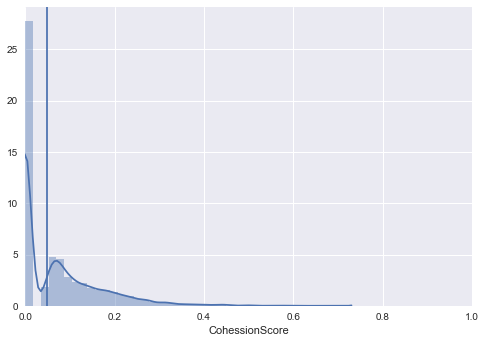

In [111]:
CreateSample(size = 1000, sd = 11)
CreateWordList()

Simulation 2

length of word_list =  10
(1050, 4)
length of word_list =  7
(1044, 4)


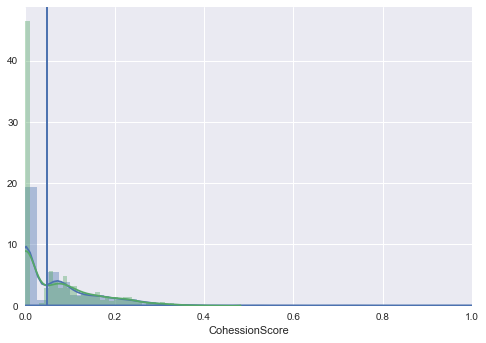

In [148]:
CreateSample(size = 10, sd = 11)

CreateSample(size = 10, sd = 18)

plt.show()

Simulation 3

length of word_list =  64
(7649, 4)
length of word_list =  69
(8827, 4)


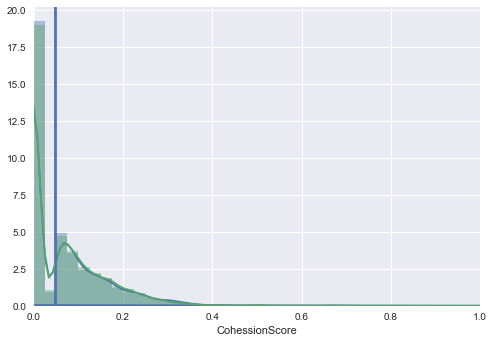

In [149]:
CreateSample(size = 100, sd = 64654)

CreateSample(size = 100, sd = 465132)

plt.show()

Simulation 4

length of word_list =  310
(38708, 4)
length of word_list =  314
(37885, 4)
length of word_list =  308
(36408, 4)


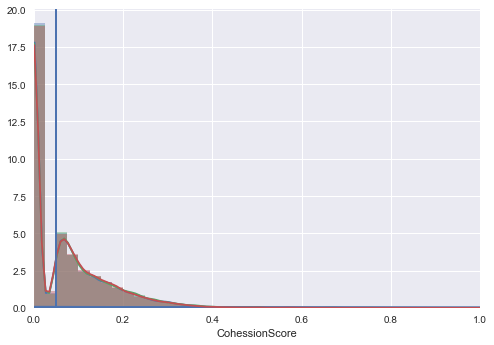

In [150]:
CreateSample(size = 500, sd = 64654)
CreateSample(size = 500, sd = 46512)
CreateSample(size = 500, sd = 4632)

plt.show()

In [151]:
CreateSample(size = 1500, sd = 6454)

length of word_list =  991
(121192, 4)


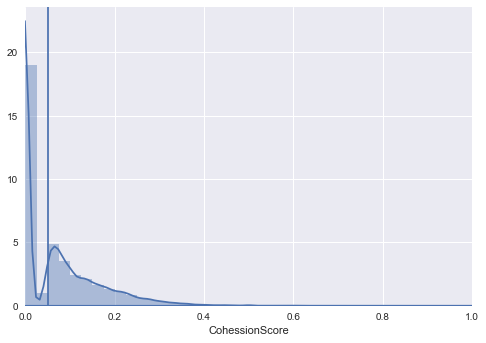

In [152]:
plt.show()

In [153]:
CreateSample(size = 1500, sd = 6)

length of word_list =  970
(118029, 4)


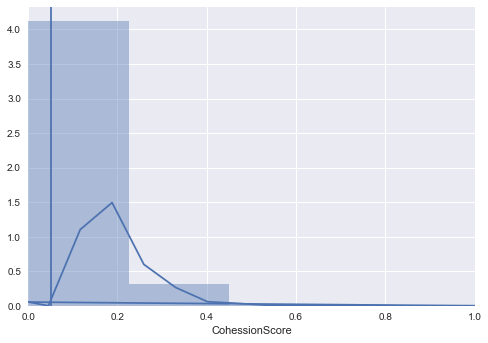

In [154]:
plt.show()

length of word_list =  936
(113089, 4)


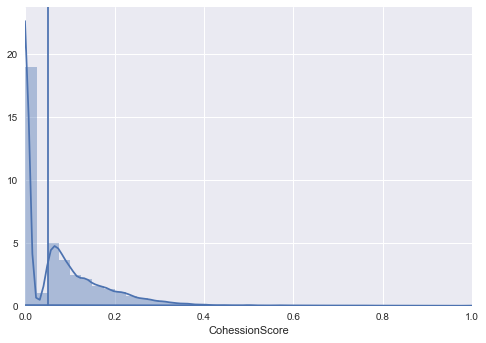

In [155]:
CreateSample(size = 1500, sd = 463)
plt.show()

length of word_list =  936
(113089, 4)


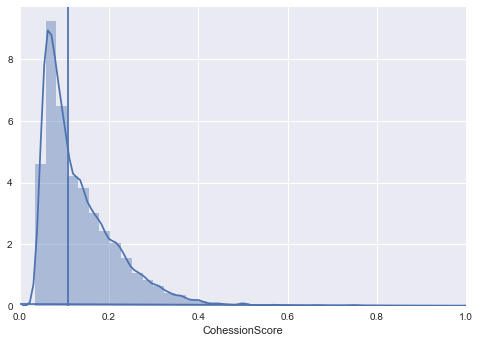

In [164]:
# Without stop words
ignore_zero = True
CreateSample(size = 1500, sd = 463)
plt.show()

length of word_list =  929
(113813, 4)


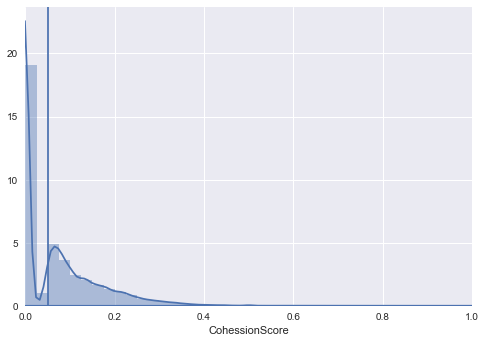

length of word_list =  929
(113813, 4)


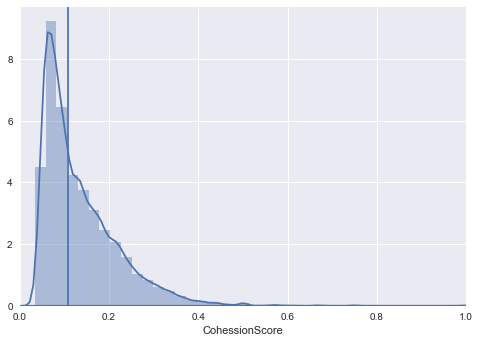

In [167]:
# Without stop words
ignore_zero = False
CreateSample(size = 1500, sd = 1463)
plt.show()
ignore_zero = True
CreateSample(size = 1500, sd = 1463)
plt.show()

length of word_list =  949
(115865, 4)


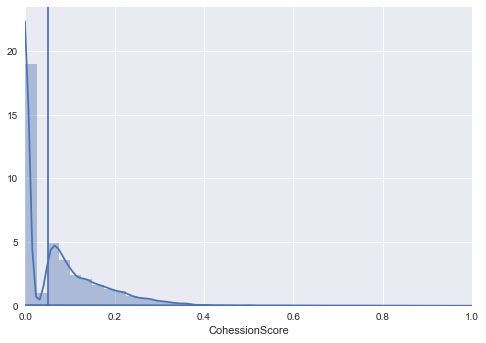

length of word_list =  949
(115865, 4)


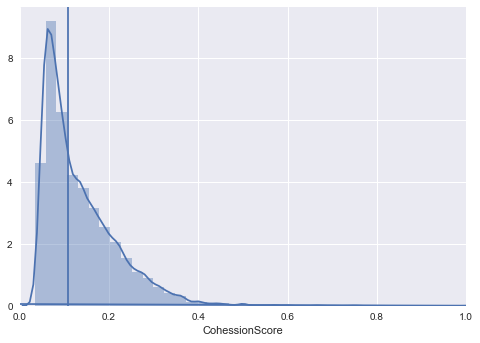

In [168]:
# Without stop words
ignore_zero = False
CreateSample(size = 1500, sd = 2003)
plt.show()
ignore_zero = True
CreateSample(size = 1500, sd = 2003)
plt.show()

length of word_list =  959
(121471, 4)


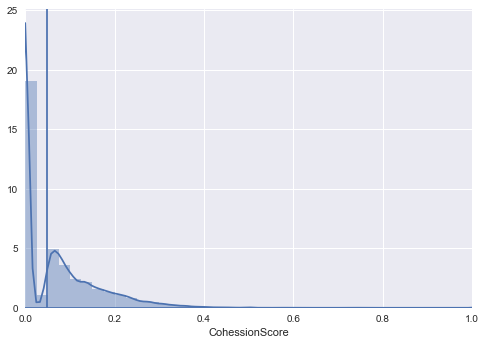

length of word_list =  959
(121471, 4)


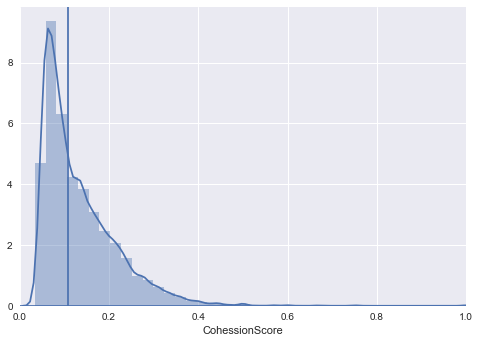

In [169]:
# Without stop words
ignore_zero = False
CreateSample(size = 1500, sd = 2449003)
plt.show()
ignore_zero = True
CreateSample(size = 1500, sd = 2449003)
plt.show()

English Ethnicity authors

In [13]:
english_authors = authors_data[authors_data.ethnicities == "ENGLISH"]
english_authors.shape

(118329, 9)

In [14]:
english_indx = english_authors.index

In [28]:
ignore_zero = False
CreateSample_custom(list(english_indx), 1000)

length of word_list =  661
(77502, 4)


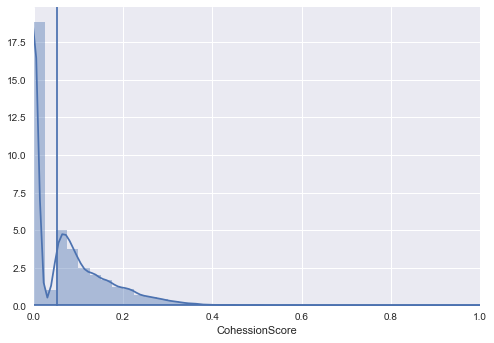

In [29]:
plt.show()

length of word_list =  690
(81295, 4)
norm  with params:  (0.069329657153576488, 0.088871328324747645)


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_continuous_distns.py:404: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


beta  with params:  (0.34849735313367869, 113.85891035483922, -6.9424234560622053e-29, 5.5979008087391087)
gamma  with params:  (0.26476880360066291, -6.9555470043607475e-30, 0.088381567853199255)
weibull_min  with params:  (0.079523611065378641, -4.4636141295312163e-32, 0.13564363654549691)
rayleigh  with params:  (-0.064843550375748543, 0.11379952298891288)


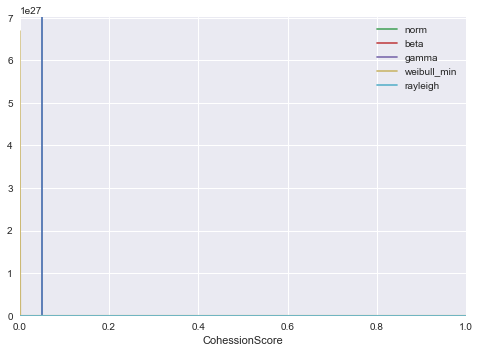

In [57]:
ignore_zero = False
CreateSample_custom(list(english_indx), 1000, sd = 109343)

In [58]:
plt.show()

length of word_list =  690
(81295, 4)


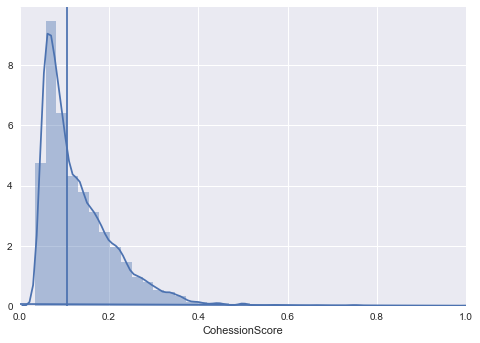

In [32]:
ignore_zero = True
CreateSample_custom(list(english_indx), 1000, sd = 109343)
plt.show()

length of word_list =  667
(78404, 4)


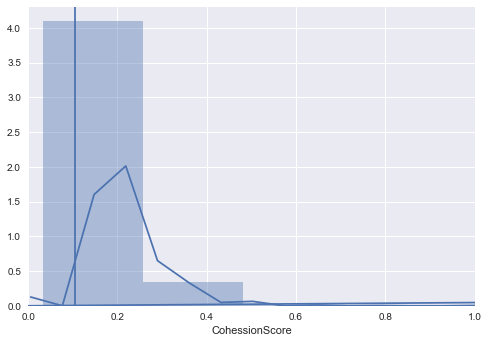

In [15]:
ignore_zero = True
CreateSample_custom(list(english_indx), 1000, sd = 1343)
plt.show()

German

In [15]:
german_authors = authors_data[authors_data.ethnicities == "GERMAN"]
german_authors.shape

(20044, 9)

In [16]:
german_indx = german_authors.index

length of word_list =  627
(75203, 4)


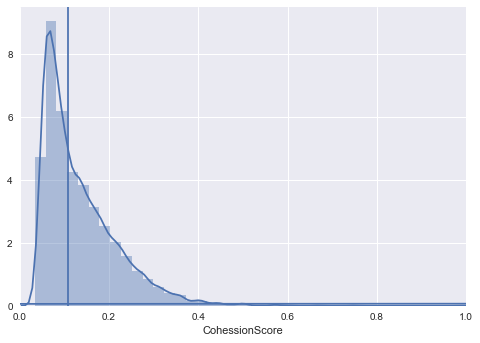

In [18]:
ignore_zero = True
CreateSample_custom(list(german_indx), 1000, sd = 1343)
plt.show()

length of word_list =  607
(76748, 4)


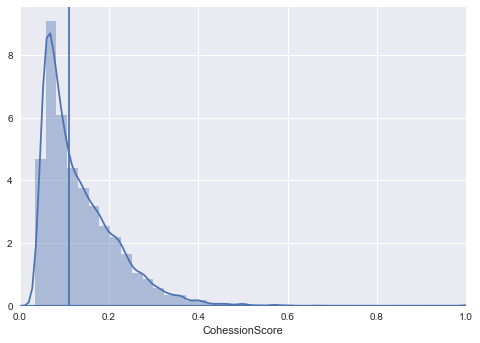

In [19]:
ignore_zero = True
CreateSample_custom(list(german_indx), 1000, sd = 1)
plt.show()

length of word_list =  6
(917, 4)
[ 0.          0.001001    0.002002    0.003003    0.004004    0.00500501
  0.00600601  0.00700701  0.00800801  0.00900901  0.01001001  0.01101101
  0.01201201  0.01301301  0.01401401  0.01501502  0.01601602  0.01701702
  0.01801802  0.01901902  0.02002002  0.02102102  0.02202202  0.02302302
  0.02402402  0.02502503  0.02602603  0.02702703  0.02802803  0.02902903
  0.03003003  0.03103103  0.03203203  0.03303303  0.03403403  0.03503504
  0.03603604  0.03703704  0.03803804  0.03903904  0.04004004  0.04104104
  0.04204204  0.04304304  0.04404404  0.04504505  0.04604605  0.04704705
  0.04804805  0.04904905  0.05005005  0.05105105  0.05205205  0.05305305
  0.05405405  0.05505506  0.05605606  0.05705706  0.05805806  0.05905906
  0.06006006  0.06106106  0.06206206  0.06306306  0.06406406  0.06506507
  0.06606607  0.06706707  0.06806807  0.06906907  0.07007007  0.07107107
  0.07207207  0.07307307  0.07407407  0.07507508  0.07607608  0.07707708
  0.07807808  0.0

  0.996997    0.997998    0.998999    1.        ]
0      0.075000
2      0.269058
3      0.192872
4      0.168605
6      0.308300
7      0.234925
9      0.064412
10     0.149488
11     0.145899
13     0.089695
16     0.062641
18     0.104421
21     0.046886
22     0.071329
24     0.181818
26     0.150722
30     0.053427
33     0.056217
35     0.053252
38     0.112583
41     0.080488
44     0.235828
46     0.329715
48     0.085417
52     0.070952
53     0.140439
56     0.054704
58     0.077137
59     0.159152
61     0.047675
         ...   
858    0.134619
861    0.070014
864    0.144795
865    0.041575
867    0.132851
869    0.106796
870    0.070014
872    0.080293
875    0.070014
877    0.162641
879    0.088179
880    0.040925
882    0.166181
884    0.226415
885    0.218531
889    0.134619
890    0.129525
892    0.099817
894    0.074579
896    0.156494
898    0.070014
899    0.082921
901    0.069101
904    0.108382
906    0.106089
908    0.147368
909    0.079147
912    0.057610
915   

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_distn_infrastructure.py:2303: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


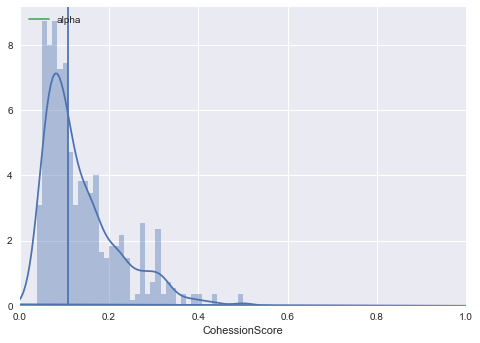

In [41]:
ignore_zero = True
CreateSample_custom(list(german_indx), 10, sd = 8)
plt.show()

length of word_list =  6
(917, 4)
norm  with params:  (0.13747774558823528, 0.083934087094202595)


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_continuous_distns.py:404: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


beta  with params:  (1.4601053019767294, 883121927.65384245, 0.037692708874325562, 60550733.569533587)
gamma  with params:  (1.4727390890188641, 0.037679142409976191, 0.067764745113670283)
weibull_min  with params:  (1.2315215870170815, 0.037844051556451472, 0.10692313910938295)
rayleigh  with params:  (0.0070778569183041797, 0.10965261018104372)


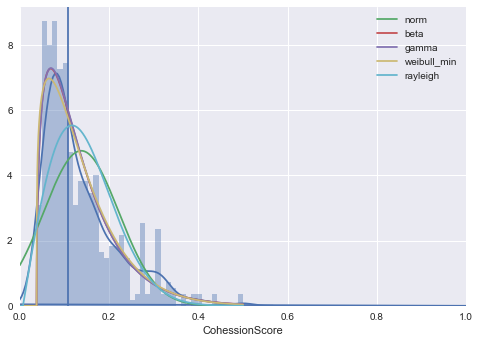

In [55]:
ignore_zero = True
CreateSample_custom(list(german_indx), 10, sd = 8)
plt.show()

length of word_list =  608
(74456, 4)
norm  with params:  (0.13295714763211383, 0.082351472576956311)


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_continuous_distns.py:404: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


beta  with params:  (1.6245853857381665, 104787101609.64, 0.033416230087330107, 6432060347.505476)
gamma  with params:  (1.6326717951994656, 0.033415148883821945, 0.060969496904471218)
weibull_min  with params:  (1.2922573597107332, 0.033439159389783479, 0.11091077422155751)
rayleigh  with params:  (0.0059598935653332749, 0.10702920883193404)


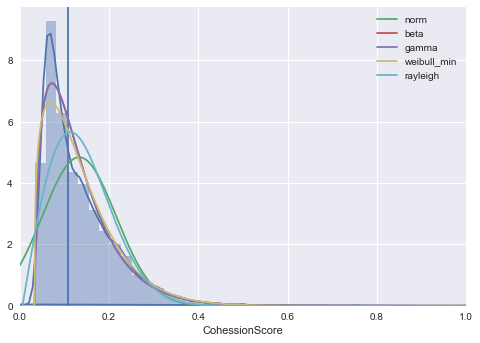

In [56]:
ignore_zero = True
CreateSample_custom(list(german_indx), 1000, sd = 8)
plt.show()

length of word_list =  1
(247, 4)
norm  with params:  (0.14071347222222222, 0.096515950417388766)


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_continuous_distns.py:404: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


beta  with params:  (0.92441868760791546, 44.397797832056945, 0.042567999999999995, 5.0250431540082054)
gamma  with params:  (0.94835525845390278, 0.042567999999999995, 0.10693510392341576)
weibull_min  with params:  (0.92355298456425161, 0.042567999999999995, 0.090522127977592182)
rayleigh  with params:  (-0.0047486098223230187, 0.12344905227254739)


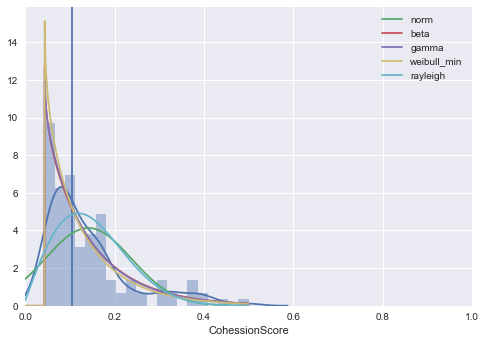

In [19]:
ignore_zero = True
CreateSample_custom(list(german_indx), 1, sd = 8)
plt.show()

length of word_list =  1
(155, 4)
norm  with params:  (0.11739913157894737, 0.091712470139474506)


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_continuous_distns.py:404: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


beta  with params:  (0.86416607347868002, 119.65133522892562, 0.045441599999999992, 10.336544238353863)
gamma  with params:  (0.76194272695854648, 0.045441599999999992, 0.10003269780657993)
weibull_min  with params:  (0.87410829715519189, 0.045441599999999992, 0.068299224623048674)
rayleigh  with params:  (-0.0062729301900966566, 0.10886460102066628)


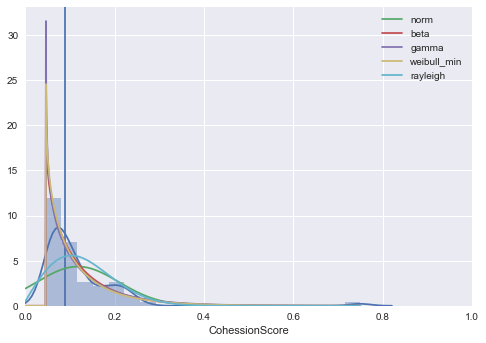

In [29]:
ignore_zero = True
CreateSample_custom(list(german_indx), 1, sd = 132)
plt.show()

Seperating two normal distributions 

http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=17393406
length of word_list =  1
(155, 4)
Means:  [[ 0.19695426]
 [ 0.0800005 ]]
Covariances:  [[[ 0.01585361]]

 [[ 0.00054007]]]


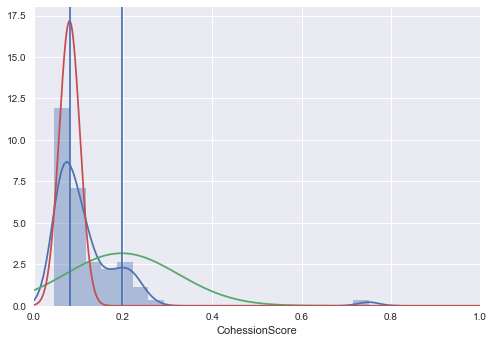

In [93]:
fit_multiple_dist = False
ignore_zero = True
CreateSample_custom(list(german_indx), 1, sd = 132)
plt.show()

http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=9861668
length of word_list =  1
(80, 4)
Means:  [[ 0.25660522]
 [ 0.10769553]]
Covariances:  [[[ 0.00068702]]

 [[ 0.00213361]]]


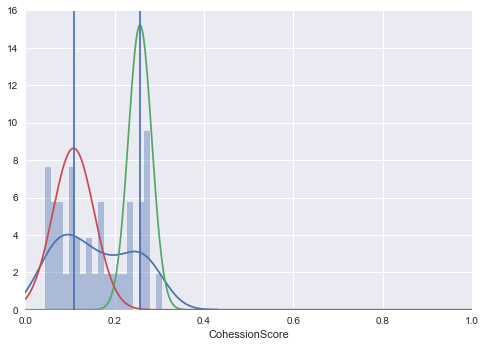

In [92]:
fit_multiple_dist = False
ignore_zero = True
CreateSample_custom(list(german_indx), 1, sd = 133)
plt.show()

http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=17102067
length of word_list =  1
(75, 4)
Means:  [[ 0.21935202]
 [ 0.07673036]]
Covariances:  [[[ 0.00713747]]

 [[ 0.00045558]]]


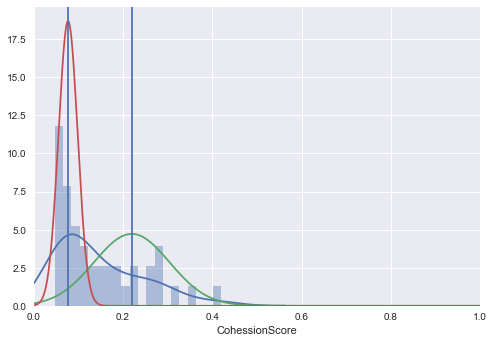

In [91]:
fit_multiple_dist = False
ignore_zero = True
CreateSample_custom(list(german_indx), 1, sd = 13332)
plt.show()

http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=18000898
length of word_list =  1
(182, 4)
Means:  [[ 0.23756452]
 [ 0.09203649]]
Covariances:  [[[ 0.00794792]]

 [[ 0.00127477]]]


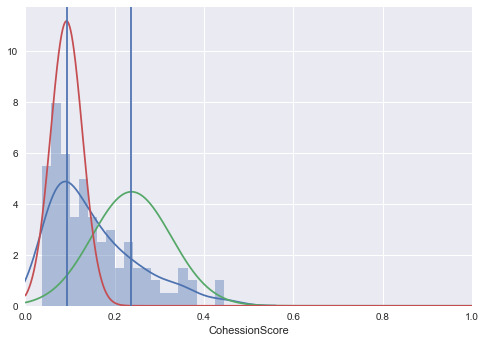

In [90]:
fit_multiple_dist = False
ignore_zero = True
CreateSample_custom(list(german_indx), 1, sd = 4332)
plt.show()

http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=18500472
length of word_list =  1
(73, 4)
Means:  [[ 0.18888267]
 [ 0.06897138]]
Covariances:  [[[ 0.00680176]]

 [[ 0.00025808]]]


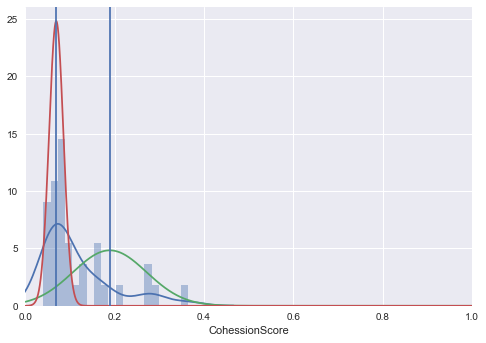

In [89]:
fit_multiple_dist = False
ignore_zero = True
CreateSample_custom(list(german_indx), 1, sd = 98332)
plt.show()

http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=18500472
length of word_list =  1
(73, 4)
Means:  [[ 0.06897138]
 [ 0.18888267]]
Covariances:  [[[ 0.00025808]]

 [[ 0.00680176]]]


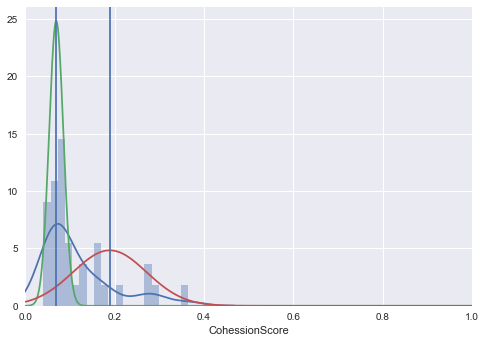

In [88]:
fit_multiple_dist = False
ignore_zero = True
CreateSample_custom(list(german_indx), 1, sd = 98332)
plt.show()

http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=12434681
length of word_list =  1
(161, 4)
Means:  [[ 0.18699025]
 [ 0.077465  ]]
Covariances:  [[[ 0.00470329]]

 [[ 0.00039992]]]


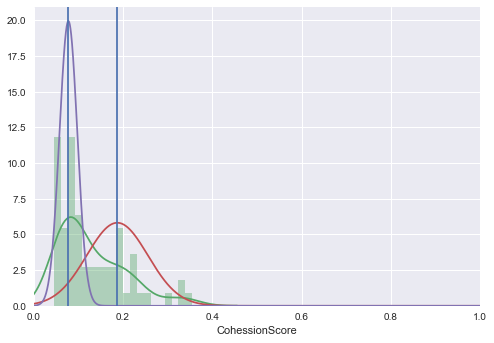

In [95]:
fit_multiple_dist = False
ignore_zero = True
CreateSample_custom(list(german_indx), 1, sd = 32)
plt.show()

### Analyzing papers of same authors

In [21]:
same_authors = authors_data.groupby(['lastname', 'fn']).size().to_frame('group_size').reset_index()
same_authors = same_authors[same_authors.group_size>1]

num_bins =  20
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=17521531
(46, 4)
Means:  [ 0.13900696]   [ 0.5]
Covariances:  [[ 0.00503536]]   [[  1.00000000e-06]]


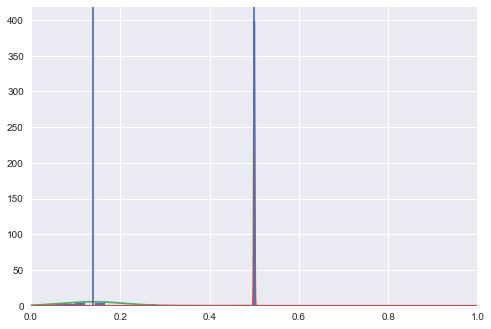

Left Normal Curve score =  0.954545486829
Right Normal Curve score =  0.0454545131713
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.9545454545454546
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=16999893
(58, 4)
Means:  [ 0.08821112]   [ 0.20162707]
Covariances:  [[ 0.00078057]]   [[ 0.00389951]]


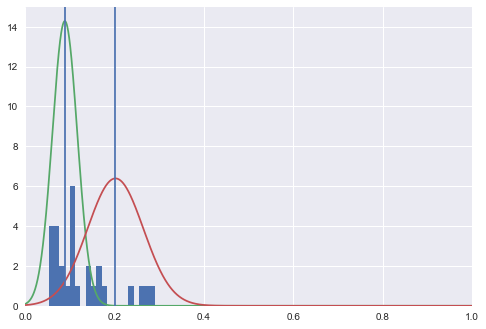

Left Normal Curve score =  0.675590852193
Right Normal Curve score =  0.324409147807
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.6785714285714286
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


In [74]:
idx = 1
num_bins = 20
print("num_bins = ", num_bins)
b,a = same_authors.iloc[idx][['lastname', 'fn']]
tst = authors_data[(authors_data.fn==a) & (authors_data.lastname==b)]
smp = list(tst.index)
ignore_zero = True
for s in smp:
    CreateWordList([s])

num_bins =  20
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=16354955
(117, 4)
Means:  [ 0.06919812]   [ 0.19507122]
Covariances:  [[ 0.00018583]]   [[ 0.00235307]]


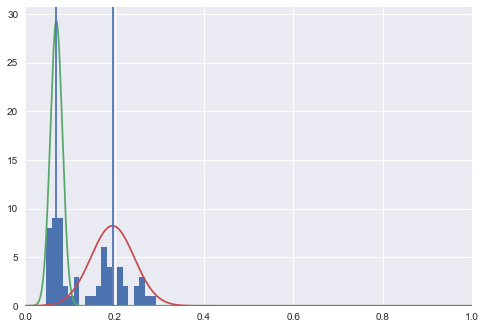

Left Normal Curve score =  0.483527241707
Right Normal Curve score =  0.516472758293
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.4915254237288136
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=16153988
(179, 4)
Means:  [ 0.06476918]   [ 0.16619307]
Covariances:  [[ 0.00015616]]   [[ 0.0036603]]


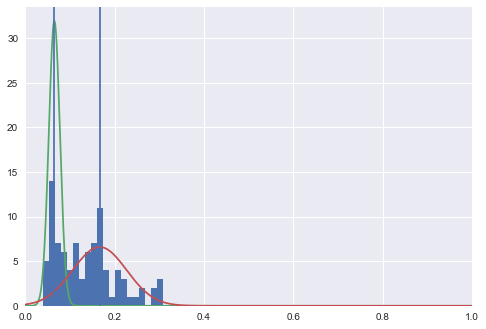

Left Normal Curve score =  0.297002320727
Right Normal Curve score =  0.702997679273
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.3516483516483517
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


In [75]:
idx = 2
num_bins = 20
print("num_bins = ", num_bins)
b,a = same_authors.iloc[idx][['lastname', 'fn']]
tst = authors_data[(authors_data.fn==a) & (authors_data.lastname==b)]
smp = list(tst.index)
ignore_zero = True
for s in smp:
    CreateWordList([s])

num_bins =  20
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=11115234
(147, 4)
Means:  [ 0.09587485]   [ 0.2404902]
Covariances:  [[ 0.00121867]]   [[ 0.00154483]]


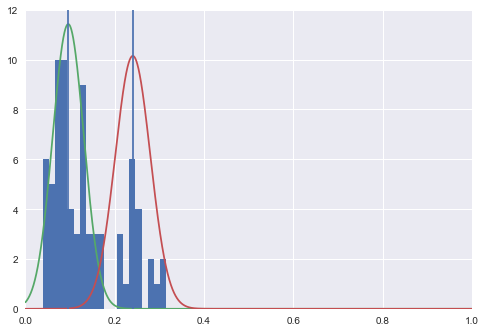

Left Normal Curve score =  0.72124544652
Right Normal Curve score =  0.27875455348
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.7333333333333333
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=9923757
(107, 4)
Means:  [ 0.07149033]   [ 0.13747457]
Covariances:  [[  7.96133856e-05]]   [[ 0.00238284]]


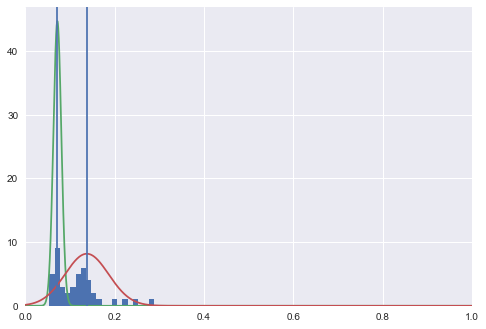

Left Normal Curve score =  0.324976834983
Right Normal Curve score =  0.675023165017
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.38636363636363635
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


In [76]:
idx = 7
num_bins = 20
print("num_bins = ", num_bins)
b,a = same_authors.iloc[idx][['lastname', 'fn']]
tst = authors_data[(authors_data.fn==a) & (authors_data.lastname==b)]
smp = list(tst.index)
ignore_zero = True
for s in smp:
    CreateWordList([s])

num_bins =  20
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=18794013
(147, 4)
Means:  [ 0.07593447]   [ 0.20118597]
Covariances:  [[ 0.00037376]]   [[ 0.00111951]]


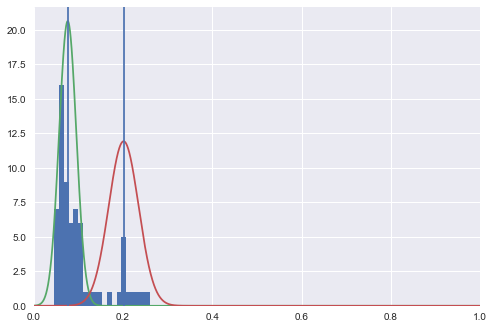

Left Normal Curve score =  0.790330859432
Right Normal Curve score =  0.209669140568
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.7910447761194029
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=16631277
(40, 4)
Means:  [ 0.18618461]   [ 0.07600738]
Covariances:  [[ 0.00066477]]   [[ 0.00059929]]


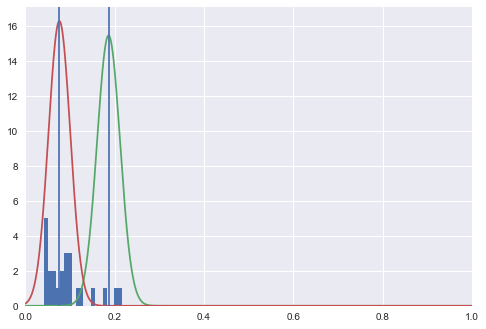

Left Normal Curve score =  0.16748050302
Right Normal Curve score =  0.83251949698
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.16666666666666666
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


In [77]:
idx = 141
num_bins = 20
print("num_bins = ", num_bins)
b,a = same_authors.iloc[idx][['lastname', 'fn']]
tst = authors_data[(authors_data.fn==a) & (authors_data.lastname==b)]
smp = list(tst.index)
ignore_zero = True
for s in smp:
    CreateWordList([s])

num_bins =  20
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=16045242
(128, 4)
Means:  [ 0.18332269]   [ 0.09369722]
Covariances:  [[ 0.00347455]]   [[ 0.00122692]]


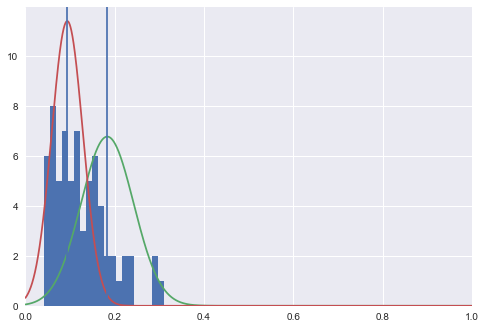

Left Normal Curve score =  0.36161936146
Right Normal Curve score =  0.63838063854
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.3235294117647059
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=15972302
(142, 4)
Means:  [ 0.0861342]   [ 0.28815084]
Covariances:  [[ 0.00116127]]   [[ 0.00979773]]


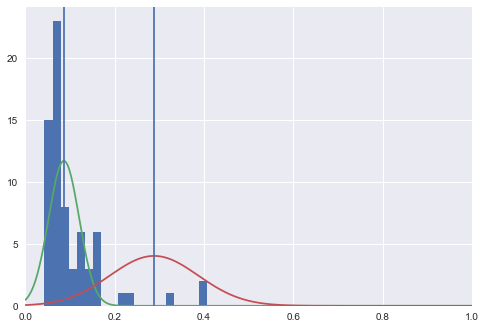

Left Normal Curve score =  0.909468882265
Right Normal Curve score =  0.0905311177351
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.927536231884058
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=16263914
(131, 4)
Means:  [ 0.07468254]   [ 0.17768353]
Covariances:  [[ 0.00026225]]   [[ 0.00194431]]


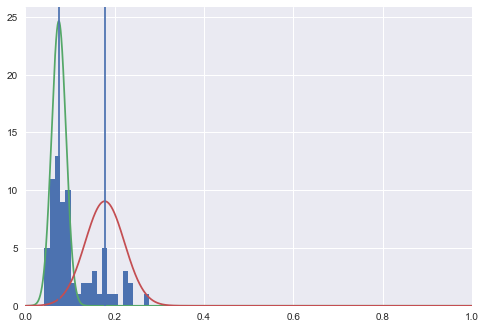

Left Normal Curve score =  0.682674044945
Right Normal Curve score =  0.317325955055
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.6944444444444444
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=17102064
(115, 4)
Means:  [ 0.06514307]   [ 0.14069042]
Covariances:  [[ 0.00018645]]   [[ 0.00248079]]


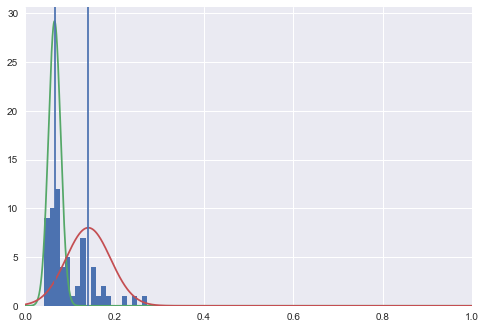

Left Normal Curve score =  0.563656477946
Right Normal Curve score =  0.436343522054
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.5901639344262295
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=11797925
(133, 4)
Means:  [ 0.1013094]   [ 0.3065473]
Covariances:  [[ 0.002378]]   [[ 0.01910242]]


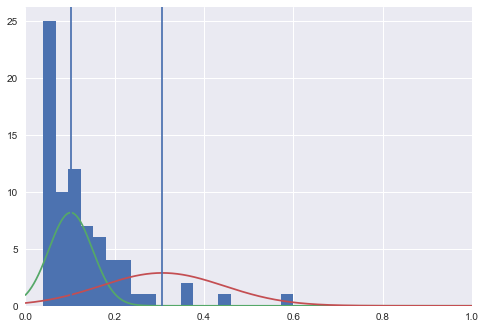

Left Normal Curve score =  0.866377787062
Right Normal Curve score =  0.133622212938
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.8918918918918919
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


In [78]:
idx = 89
num_bins = 20
print("num_bins = ", num_bins)
b,a = same_authors.iloc[idx][['lastname', 'fn']]
tst = authors_data[(authors_data.fn==a) & (authors_data.lastname==b)]
smp = list(tst.index)
ignore_zero = True
for s in smp:
    CreateWordList([s])

http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=17575471
(195, 4)
Means:  [ 0.21527404]   [ 0.07721861]
Covariances:  [[ 0.00427682]]   [[ 0.00055883]]


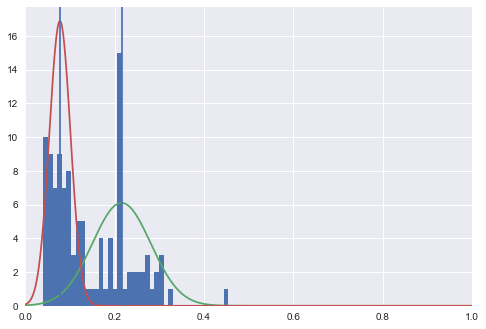

Left Normal Curve score =  0.49466751979
Right Normal Curve score =  0.50533248021
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.4594594594594595
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=18764741
(101, 4)
Means:  [ 0.07016736]   [ 0.1797058]
Covariances:  [[ 0.00027162]]   [[ 0.00334343]]


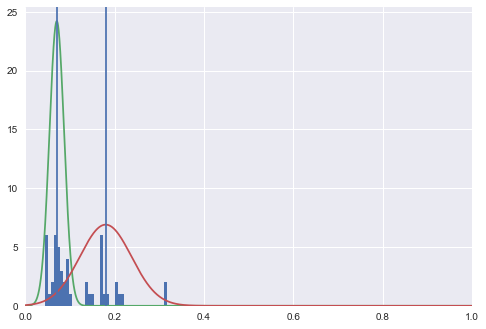

Left Normal Curve score =  0.580856277719
Right Normal Curve score =  0.419143722281
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.625
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


In [67]:
num_bins = 40
b,a = same_authors.iloc[90][['lastname', 'fn']]
tst = authors_data[(authors_data.fn==a) & (authors_data.lastname==b)]
smp = list(tst.index)
ignore_zero = True
for s in smp:
    CreateWordList([s])

http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=17575471
(195, 4)
Means:  [ 0.07721861]   [ 0.21527404]
Covariances:  [[ 0.00055883]]   [[ 0.00427682]]


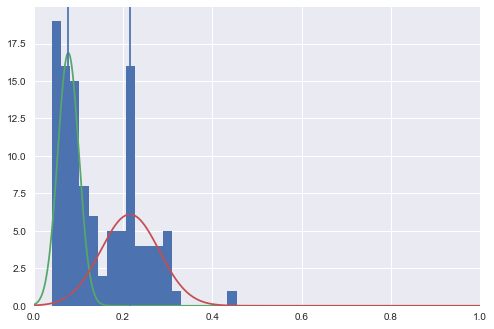

Left Normal Curve score =  0.50533248021
Right Normal Curve score =  0.49466751979
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.5405405405405406
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=18764741
(101, 4)
Means:  [ 0.07016736]   [ 0.1797058]
Covariances:  [[ 0.00027162]]   [[ 0.00334343]]


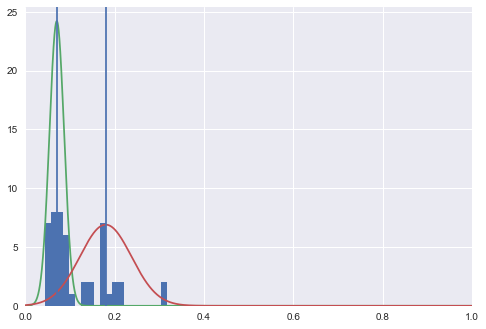

Left Normal Curve score =  0.580856277719
Right Normal Curve score =  0.419143722281
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.625
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


In [79]:
num_bins = 20
b,a = same_authors.iloc[90][['lastname', 'fn']]
tst = authors_data[(authors_data.fn==a) & (authors_data.lastname==b)]
smp = list(tst.index)
ignore_zero = True
for s in smp:
    CreateWordList([s])

num_bins =  20
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=14556381
(80, 4)
Means:  [ 0.19153725]   [ 0.07854731]
Covariances:  [[ 0.00036974]]   [[ 0.00057844]]


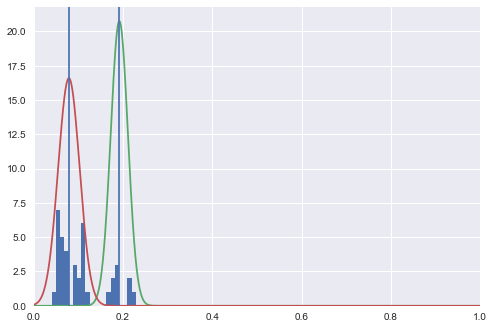

Left Normal Curve score =  0.236800378895
Right Normal Curve score =  0.763199621105
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.23684210526315788
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=17151552
(159, 4)
Means:  [ 0.11208456]   [ 0.30593958]
Covariances:  [[ 0.0016809]]   [[ 0.00517513]]


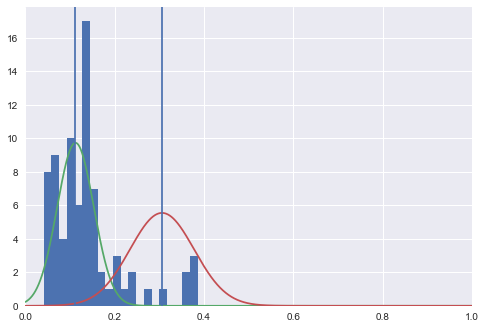

Left Normal Curve score =  0.860101283227
Right Normal Curve score =  0.139898716773
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.8701298701298701
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


In [80]:
idx = 111
num_bins = 20
print("num_bins = ", num_bins)
b,a = same_authors.iloc[idx][['lastname', 'fn']]
tst = authors_data[(authors_data.fn==a) & (authors_data.lastname==b)]
smp = list(tst.index)
ignore_zero = True
for s in smp:
    CreateWordList([s])

num_bins =  20
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=12884883
(111, 4)
Means:  [ 0.22028442]   [ 0.08769532]
Covariances:  [[ 0.01042162]]   [[ 0.00087238]]


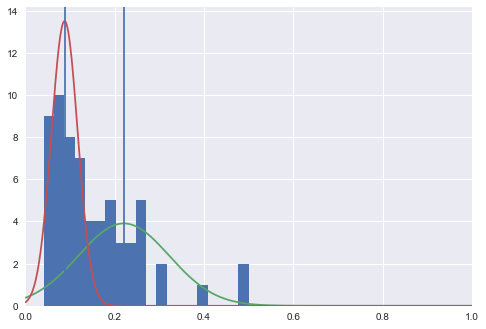

Left Normal Curve score =  0.50843632785
Right Normal Curve score =  0.49156367215
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.4603174603174603
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=2336066
(364, 4)
Means:  [ 0.23583989]   [ 0.08518691]
Covariances:  [[ 0.00663726]]   [[ 0.00083356]]


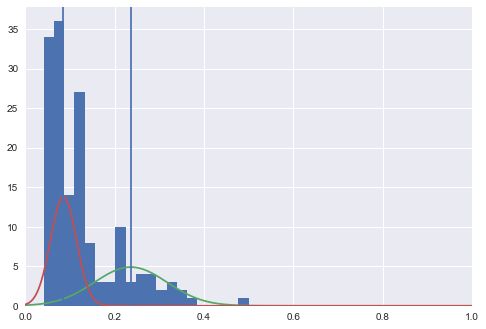

Left Normal Curve score =  0.276667044157
Right Normal Curve score =  0.723332955843
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.23870967741935484
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=9054346
(96, 4)
Means:  [ 0.08717264]   [ 0.17246954]
Covariances:  [[ 0.00074035]]   [[ 0.00303296]]


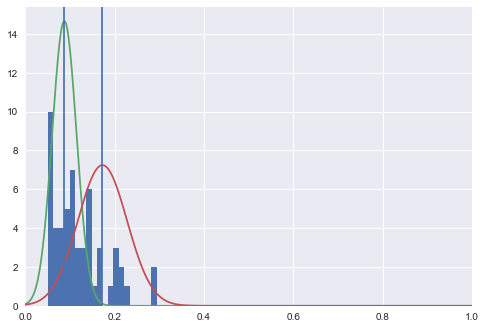

Left Normal Curve score =  0.598114519875
Right Normal Curve score =  0.401885480125
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.6545454545454545
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=10719138
(68, 4)
Means:  [ 0.07610436]   [ 0.15998684]
Covariances:  [[ 0.00031455]]   [[ 0.00098438]]


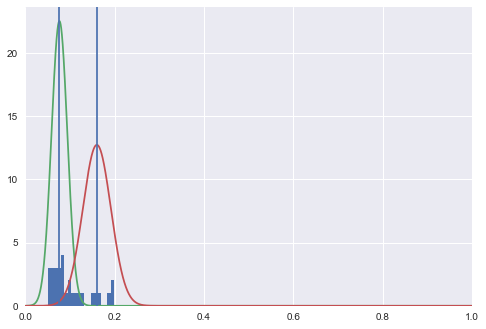

Left Normal Curve score =  0.703946954166
Right Normal Curve score =  0.296053045834
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.7241379310344828
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


In [81]:
idx = 1114
num_bins = 20
print("num_bins = ", num_bins)
b,a = same_authors.iloc[idx][['lastname', 'fn']]
tst = authors_data[(authors_data.fn==a) & (authors_data.lastname==b)]
smp = list(tst.index)
ignore_zero = True
for s in smp:
    CreateWordList([s])

num_bins =  20
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=16816820
(153, 4)
Means:  [ 0.30797115]   [ 0.09859105]
Covariances:  [[ 0.01185931]]   [[ 0.0012152]]


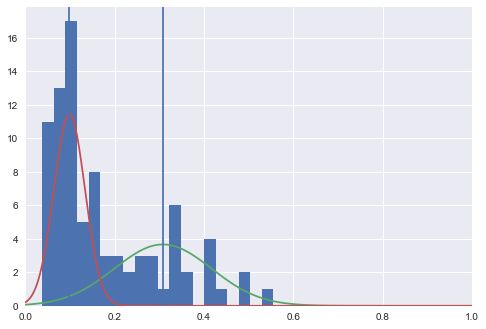

Left Normal Curve score =  0.388079582636
Right Normal Curve score =  0.611920417364
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.35294117647058826
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=18059250
(199, 4)
Means:  [ 0.09725013]   [ 0.26060829]
Covariances:  [[ 0.00102329]]   [[ 0.00113324]]


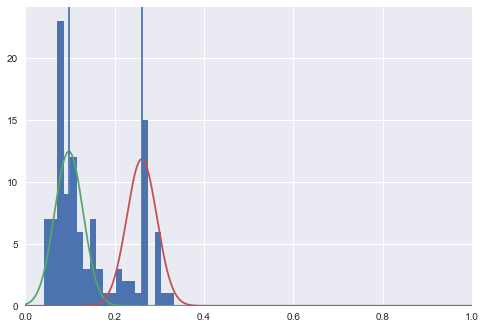

Left Normal Curve score =  0.704734266344
Right Normal Curve score =  0.295265733656
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.7090909090909091
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=17767107
(215, 4)
Means:  [ 0.20443925]   [ 0.08055532]
Covariances:  [[ 0.00664722]]   [[ 0.00058435]]


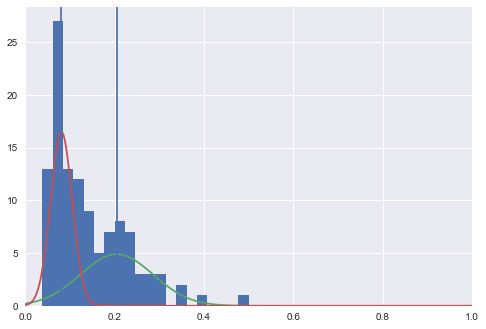

Left Normal Curve score =  0.506592750652
Right Normal Curve score =  0.493407249348
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.45614035087719296
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


In [82]:
idx = 154
num_bins = 20
print("num_bins = ", num_bins)
b,a = same_authors.iloc[idx][['lastname', 'fn']]
tst = authors_data[(authors_data.fn==a) & (authors_data.lastname==b)]
smp = list(tst.index)
ignore_zero = True
for s in smp:
    CreateWordList([s])

num_bins =  20
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=11738834
(240, 4)
Means:  [ 0.07735001]   [ 0.16964678]
Covariances:  [[ 0.00026245]]   [[ 0.00428673]]


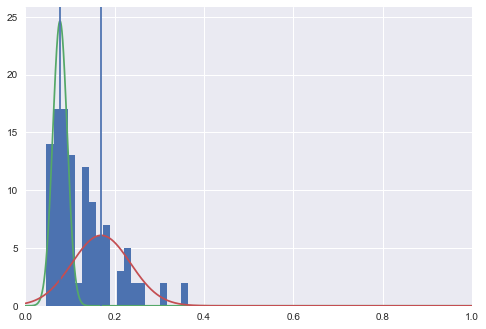

Left Normal Curve score =  0.457533812895
Right Normal Curve score =  0.542466187105
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.5309734513274337
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=11750787
(282, 4)
Means:  [ 0.19497132]   [ 0.09949223]
Covariances:  [[ 0.00479536]]   [[ 0.0012843]]


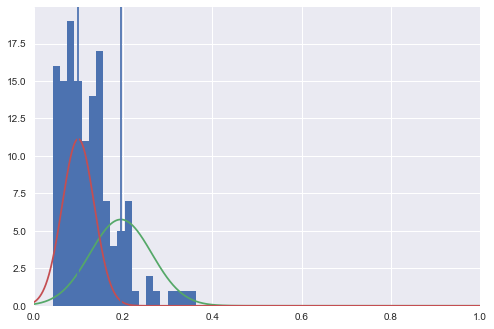

Left Normal Curve score =  0.260977766581
Right Normal Curve score =  0.739022233419
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.21739130434782608
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


In [83]:
idx = 1821
num_bins = 20
print("num_bins = ", num_bins)
b,a = same_authors.iloc[idx][['lastname', 'fn']]
tst = authors_data[(authors_data.fn==a) & (authors_data.lastname==b)]
smp = list(tst.index)
ignore_zero = True
for s in smp:
    CreateWordList([s])

num_bins =  20
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=9587891
(216, 4)
Means:  [ 0.21704022]   [ 0.08428194]
Covariances:  [[ 0.00523753]]   [[ 0.0007639]]


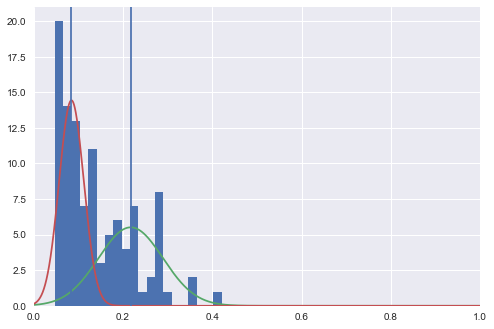

Left Normal Curve score =  0.438507512544
Right Normal Curve score =  0.561492487456
Proportion of Left (Left_score/(Left_score + Right_score)) 0.438507512544
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=9624404
(210, 4)
Means:  [ 0.0701848]   [ 0.17651678]
Covariances:  [[ 0.00021819]]   [[ 0.00654835]]


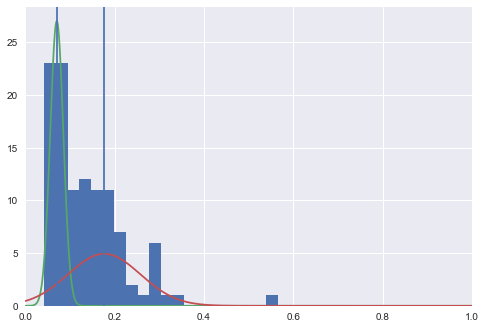

Left Normal Curve score =  0.381949367232
Right Normal Curve score =  0.618050632768
Proportion of Left (Left_score/(Left_score + Right_score)) 0.381949367232
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


In [53]:
idx = 121
num_bins = 20
print("num_bins = ", num_bins)
b,a = same_authors.iloc[idx][['lastname', 'fn']]
tst = authors_data[(authors_data.fn==a) & (authors_data.lastname==b)]
smp = list(tst.index)
ignore_zero = True
for s in smp:
    CreateWordList([s])

num_bins =  20
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=15860370
(134, 4)
Means:  [ 0.15900389]   [ 0.08045664]
Covariances:  [[ 0.00438713]]   [[ 0.00054117]]


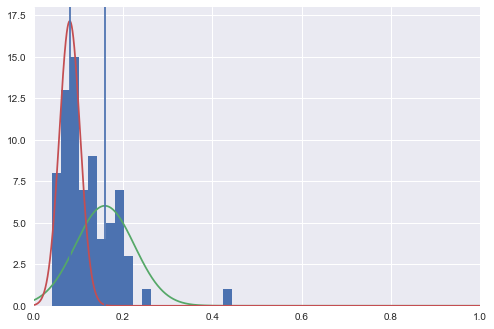

Left Normal Curve score =  0.524666124011
Right Normal Curve score =  0.475333875989
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.4520547945205479
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=16935434
(108, 4)
Means:  [ 0.07866374]   [ 0.22970013]
Covariances:  [[ 0.00028119]]   [[ 0.00994679]]


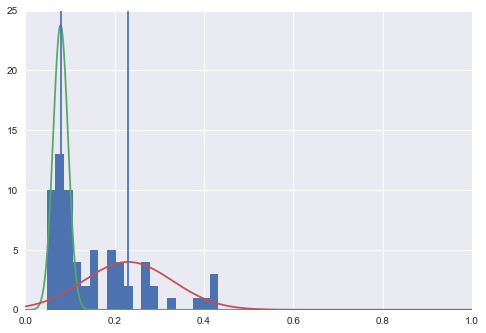

Left Normal Curve score =  0.499936163756
Right Normal Curve score =  0.500063836244
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.5522388059701493
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=11864735
(272, 4)
Means:  [ 0.19930685]   [ 0.08512403]
Covariances:  [[ 0.00482346]]   [[ 0.00093496]]


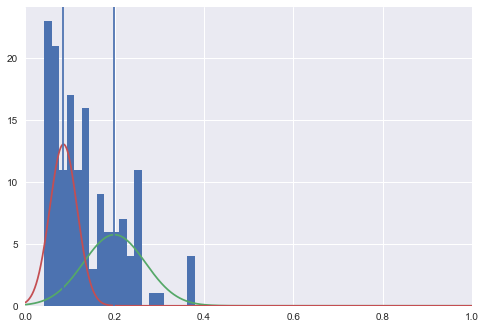

Left Normal Curve score =  0.437603766034
Right Normal Curve score =  0.562396233966
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.3576158940397351
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=16337747
(104, 4)
Means:  [ 0.08023596]   [ 0.20906268]
Covariances:  [[ 0.00040731]]   [[ 0.00718181]]


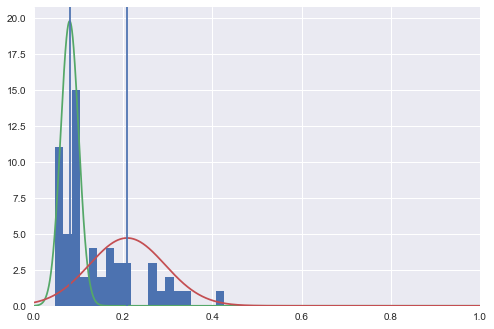

Left Normal Curve score =  0.535039714573
Right Normal Curve score =  0.464960285427
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.5689655172413793
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
http://abel.lis.illinois.edu/cgi-bin/cohese/search.py?PMIDs=12732219
(172, 4)
Means:  [ 0.07355286]   [ 0.16202313]
Covariances:  [[ 0.00034804]]   [[ 0.00255598]]


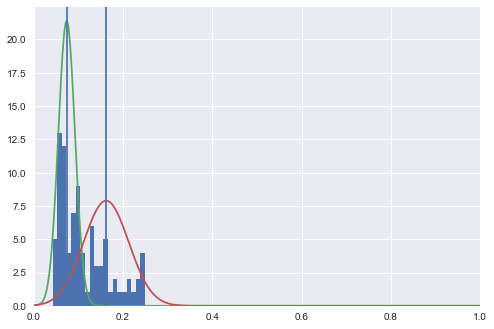

Left Normal Curve score =  0.553448378628
Right Normal Curve score =  0.446551621372
----------------------------------------------------------------------------------
Proportion of left Normal Curve:  0.6046511627906976
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------


In [84]:
idx = 999
num_bins = 20
print("num_bins = ", num_bins)
b,a = same_authors.iloc[idx][['lastname', 'fn']]
tst = authors_data[(authors_data.fn==a) & (authors_data.lastname==b)]
smp = list(tst.index)
ignore_zero = True
for s in smp:
    CreateWordList([s])